## Imports and Dataset Setup

Core libraries for data analysis, visualization, and regression modeling are imported in this section.


In [ ]:
# -------------------------------
# 1. Imports and Dataset
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


## Load and Inspect the Dataset

Load the dataset and preview the first few rows to confirm structure and contents.


In [ ]:
# Load dataset
df = pd.read_csv("../DATA/corrosion_synthetic_timeseries.csv")
print(df.head())

       timestamp    pH  temperature_C  chloride_ppm  dissolved_oxygen_mgL  \
0  7/1/2025 0:00  7.80      32.710718           216                  7.83   
1  7/1/2025 1:00  7.42      43.246618           189                  7.29   
2  7/1/2025 2:00  7.89      43.584807           241                  7.46   
3  7/1/2025 3:00  8.41      46.342352            89                  7.09   
4  7/1/2025 4:00  7.36      51.909469           212                  7.54   

   flow_velocity_mps  corrosion_rate_mm_per_yr  
0              0.538                    0.0366  
1              0.644                    0.0283  
2              0.650                    0.0527  
3              0.915                    0.0461  
4              1.441                    0.0435  


##  Feature Engineering: Nonlinear pH Term

A squared pH feature is created to capture potential nonlinear (U-shaped) effects of pH on corrosion rate that may not be adequately modeled using a purely linear term.


In [ ]:
# Add pH² to capture U-shaped effect
df["pH_squared"] = df["pH"]**2

##  Feature and Target Definition

The input feature set is defined using selected environmental and operational variables, including the engineered nonlinear pH² term.  
The target variable is specified as the corrosion rate (mm/year), which the models aim to predict.


In [ ]:
# Define features (5 original + derived pH²)
features = ["pH","pH_squared","temperature_C","chloride_ppm","dissolved_oxygen_mgL","flow_velocity_mps"]
X = df[features]
y = df["corrosion_rate_mm_per_yr"]

##  EDA: Corrosion Rate vs pH

Visualize the relationship between pH and corrosion rate to assess trends and potential nonlinearity.


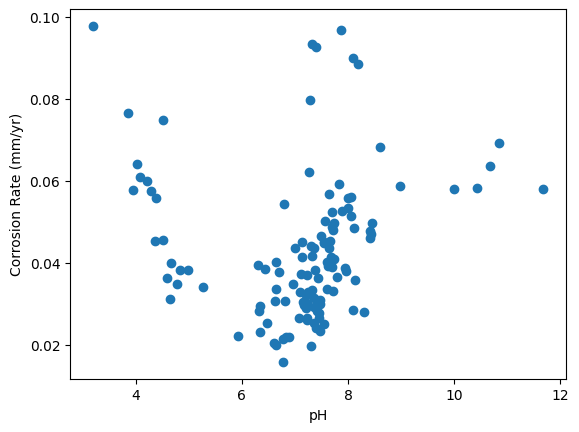

In [ ]:
# -------------------------------
# 2. Exploratory Data Analysis (EDA)
# -------------------------------
# Corrosion vs pH
plt.scatter(df["pH"], df["corrosion_rate_mm_per_yr"])
plt.xlabel("pH")
plt.ylabel("Corrosion Rate (mm/yr)")
plt.show()

## Exploratory Data Analysis: Corrosion Rate vs Temperature

This plot explores how temperature influences corrosion rate, helping assess whether increased temperature is associated with accelerated corrosion behavior.


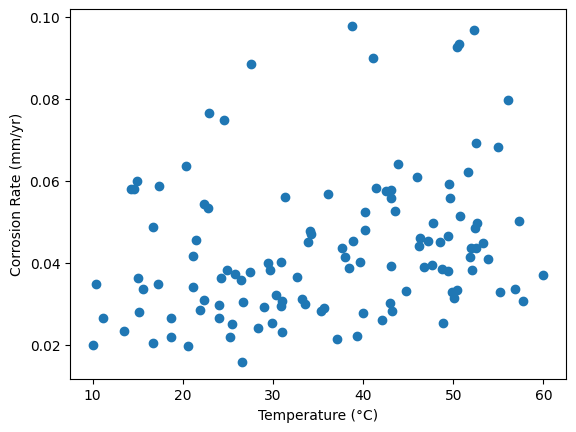

In [ ]:
# Corrosion vs Temperature
plt.scatter(df["temperature_C"], df["corrosion_rate_mm_per_yr"])
plt.xlabel("Temperature (°C)")
plt.ylabel("Corrosion Rate (mm/yr)")
plt.show()

## Exploratory Data Analysis: Corrosion Rate vs Chloride Concentration

This visualization assesses the relationship between chloride concentration and corrosion rate, highlighting the potential role of salinity and ionic content in corrosion acceleration.


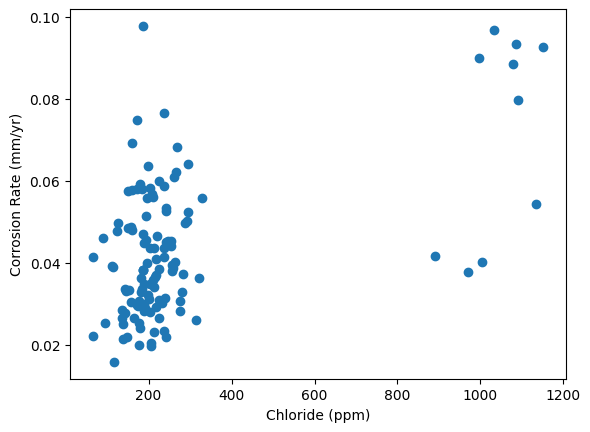

In [ ]:
# Corrosion vs Chloride
plt.scatter(df["chloride_ppm"], df["corrosion_rate_mm_per_yr"])
plt.xlabel("Chloride (ppm)")
plt.ylabel("Corrosion Rate (mm/yr)")
plt.show()

## Exploratory Data Analysis: Corrosion Rate vs Flow Velocity

This plot examines the relationship between flow velocity and corrosion rate, providing insight into potential erosion–corrosion or mass transfer effects under varying flow conditions.


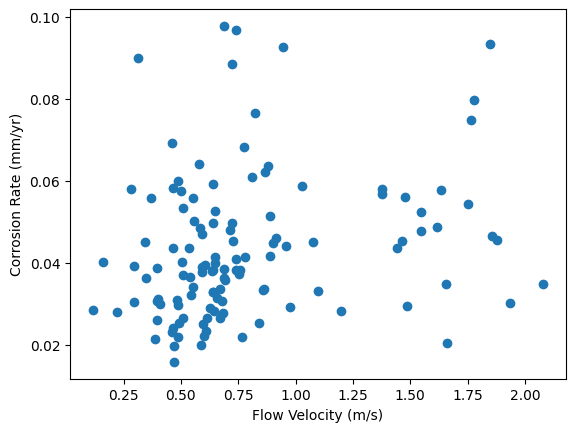

In [ ]:
# Corrosion vs Flow Velocity
plt.scatter(df["flow_velocity_mps"], df["corrosion_rate_mm_per_yr"])
plt.xlabel("Flow Velocity (m/s)")
plt.ylabel("Corrosion Rate (mm/yr)")
plt.show()


## Exploratory Data Analysis: Corrosion Rate vs Dissolved Oxygen

This visualization explores the relationship between dissolved oxygen concentration and corrosion rate, highlighting the role of oxygen availability in oxidation-driven corrosion mechanisms.


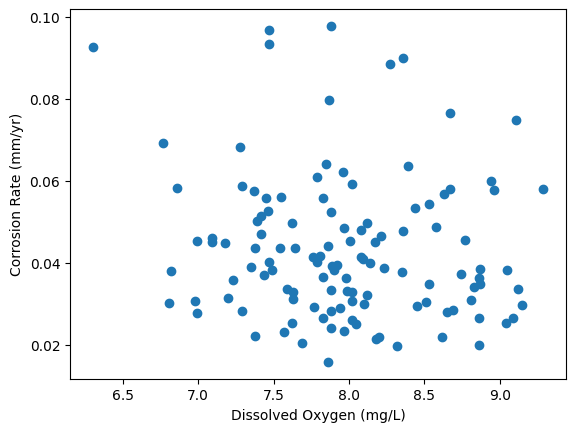

In [ ]:
# Corrosion vs Dissolved oxygen
plt.scatter(df["dissolved_oxygen_mgL"], df["corrosion_rate_mm_per_yr"])
plt.xlabel("Dissolved Oxygen (mg/L)")
plt.ylabel("Corrosion Rate (mm/yr)")
plt.show()

##  Correlation Analysis

A correlation matrix is computed and visualized to quantify linear relationships among numerical variables.  
This analysis helps identify strongly correlated features and assess potential multicollinearity prior to model training.


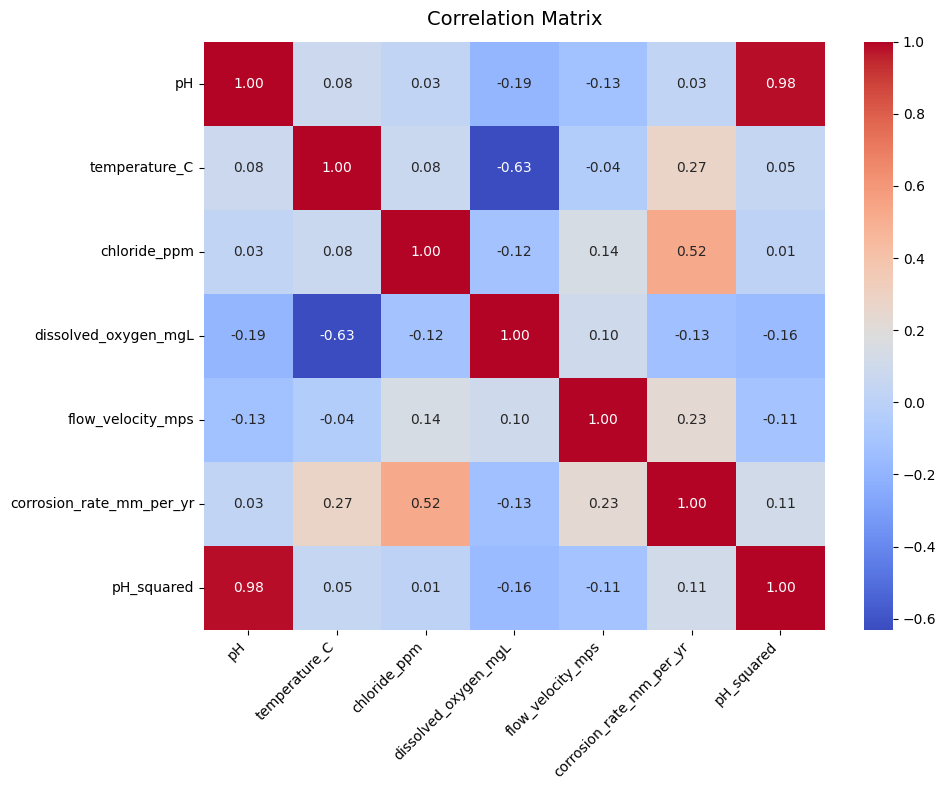

In [ ]:
# Correlation matrix
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))  # Increase figure size (width, height in inches)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()  # Prevent clipping of labels
plt.show()

## Train–Test Split

Split the data into training and testing sets for regression modeling.


In [ ]:
# -------------------------------
# 3. Regression Model with pH²
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Linear Regression Training

Train a linear regression model as a baseline predictor.


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

##  Model Coefficients and Baseline Performance

The fitted model coefficients and intercept are examined to interpret the influence of each feature on corrosion rate.  
The R² score on the test set provides an initial assessment of the model’s explanatory power.
**bold text**

In [ ]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R² score:", model.score(X_test, y_test))

Coefficients: [-3.98393628e-02  3.00064136e-03  5.40041474e-04  3.90071529e-05
  4.94227515e-03  5.81699065e-03]
Intercept: 0.09463327301202212
R² score: 0.38166594213763616


##  Predicted vs Actual Corrosion Rate

This plot compares predicted corrosion rates against observed values on the test dataset.  
Alignment along the reference line indicates good predictive agreement, while deviations highlight prediction errors and potential model bias.


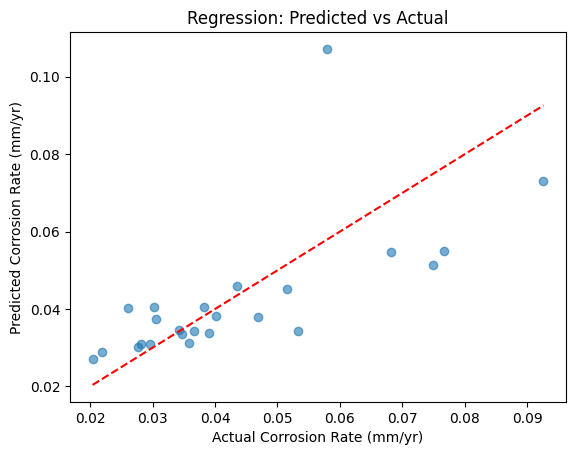

In [ ]:
## Predicted vs Actual
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Corrosion Rate (mm/yr)")
plt.ylabel("Predicted Corrosion Rate (mm/yr)")
plt.title("Regression: Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.show()


## Residual Analysis

Residuals are plotted against predicted values to assess model assumptions such as linearity and constant variance.  
Systematic patterns or increasing spread in residuals may indicate model limitations or unmodeled nonlinear effects.


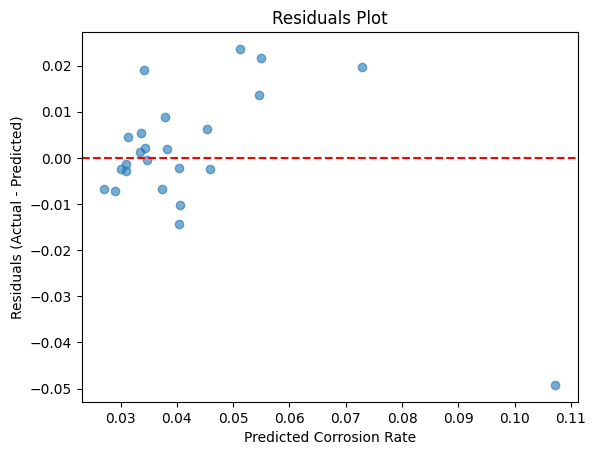

In [ ]:
# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Corrosion Rate")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot")
plt.show()

## Partial Effects: Baseline Definition

Define baseline feature values for partial effect analysis.


In [ ]:
# -------------------------------
# 5. Partial Effects
# -------------------------------
baseline = X_train.median().to_dict()

##  Partial Effect Analysis: pH Grid Construction

A range of pH values is generated to evaluate the modeled response across the observed pH spectrum.  
For each pH value, a feature vector is created while holding all other variables at baseline levels, enabling isolation of the pH effect on corrosion rate.


In [ ]:
# Partial Effect of pH
ph_grid = np.linspace(df["pH"].min(), df["pH"].max(), 80)
rows = []
for ph in ph_grid:
    r = baseline.copy()
    r["pH"] = ph
    r["pH_squared"] = ph**2
    rows.append(r)

In [ ]:
grid_df = pd.DataFrame(rows)[features]
yhat = model.predict(grid_df)

##  Partial Effect: pH

Visualize the isolated effect of pH on predicted corrosion rate.


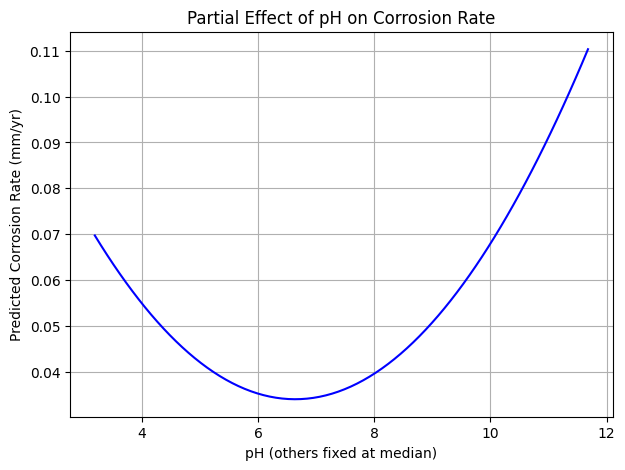

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(ph_grid, yhat, color="blue")
plt.xlabel("pH (others fixed at median)")
plt.ylabel("Predicted Corrosion Rate (mm/yr)")
plt.title("Partial Effect of pH on Corrosion Rate")
plt.grid(True)
plt.show()

## Partial Effects of Additional Variables

Partial effect analysis is extended to other key variables by varying one feature at a time while holding all remaining variables at baseline levels.  
This approach allows comparison of the isolated influence of temperature, chloride concentration, dissolved oxygen, and flow velocity on predicted corrosion rate.


In [ ]:
# Partial effects of other variables
variables = ["temperature_C","chloride_ppm","dissolved_oxygen_mgL","flow_velocity_mps"]
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

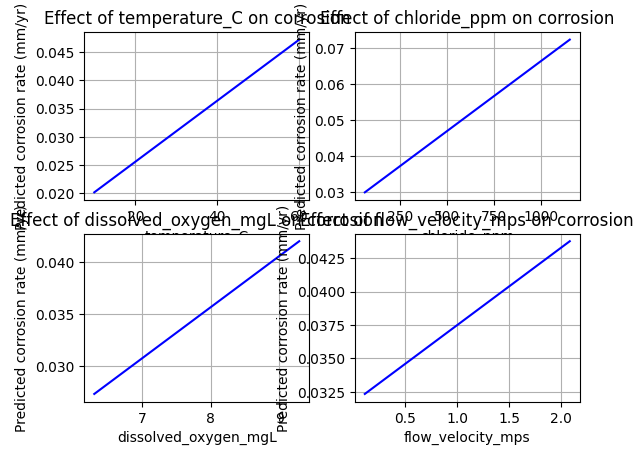

In [ ]:
for i, var in enumerate(variables, 1):
    grid = np.linspace(df[var].min(), df[var].max(), 80)
    rows = []
    for val in grid:
        r = baseline.copy()
        r[var] = val
        rows.append(r)
    grid_df = pd.DataFrame(rows)[features]
    yhat = model.predict(grid_df)

    plt.subplot(2, 2, i)
    plt.plot(grid, yhat, color="blue")
    plt.xlabel(var)
    plt.ylabel("Predicted corrosion rate (mm/yr)")
    plt.title(f"Effect of {var} on corrosion")
    plt.grid(True)

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

##  Scenario Definition for RUL Analysis

Representative operating scenarios are defined to evaluate corrosion behavior under different environmental conditions.  
These scenarios provide practical contexts for translating model predictions into Remaining Useful Life (RUL) estimates.


In [ ]:
# -------------------------------
# 6. Scenario Analysis with RUL
# -------------------------------
scenarios = [
    {"Scenario": "Seawater pipeline", "pH": 9.0, "temperature_C": 30,
     "chloride_ppm": 1000, "dissolved_oxygen_mgL": 6, "flow_velocity_mps": 1.0},
    {"Scenario": "Acidic soil", "pH": 3.0, "temperature_C": 25,
     "chloride_ppm": 200, "dissolved_oxygen_mgL": 3, "flow_velocity_mps": 0.5},
    {"Scenario": "Neutral freshwater", "pH": 6.0, "temperature_C": 20,
     "chloride_ppm": 65, "dissolved_oxygen_mgL": 8, "flow_velocity_mps": 0.3}
]

In [ ]:
allowable_loss = 1.0  # mm
results = []
for s in scenarios:
    s["pH_squared"] = s["pH"]**2
    X_scenario = pd.DataFrame([s])[features]  # enforce order
    pred_rate = float(model.predict(X_scenario)[0])
    pred_rate = max(0.0, pred_rate)  # clip negatives
    RUL = (allowable_loss / pred_rate) if pred_rate > 0 else float("inf")
    results.append({
        "Scenario": s["Scenario"],
        "Predicted corrosion (mm/yr)": round(pred_rate, 3),
        "Remaining Useful Life (years)": (round(RUL, 1) if pred_rate > 0 else "∞")
    })

## Scenario Results Summary

The predicted corrosion rates and corresponding Remaining Useful Life (RUL) estimates are summarized in tabular form for comparison across operating scenarios.


In [ ]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

          Scenario  Predicted corrosion (mm/yr)  Remaining Useful Life (years)
 Seawater pipeline                        0.070                           14.3
       Acidic soil                        0.041                           24.3
Neutral freshwater                        0.018                           54.8


## Temperature–Chloride Heatmap Setup

Prepare a 2D grid to analyze the combined effect of temperature and chloride on corrosion rate.


In [ ]:
# -------------------------------
# 7. Heatmap: Temperature × Chloride
# -------------------------------
baseline = X_train.median().to_dict()

In [ ]:
temp_grid = np.linspace(df["temperature_C"].min(), df["temperature_C"].max(), 50)
cl_grid   = np.linspace(df["chloride_ppm"].min(), df["chloride_ppm"].max(), 50)

In [ ]:
rows = []
for t in temp_grid:
    for cl in cl_grid:
        r = baseline.copy()
        r["temperature_C"] = t
        r["chloride_ppm"] = cl
        rows.append(r)

In [ ]:
grid_df = pd.DataFrame(rows)[features]  # enforce order
yhat = model.predict(grid_df)
Z = yhat.reshape(len(temp_grid), len(cl_grid))

## Temperature × Chloride Heatmap Visualization

This heatmap visualizes predicted corrosion rate across a two-dimensional operating space defined by temperature and chloride concentration.  
Regions of higher intensity indicate combinations associated with elevated corrosion risk under baseline conditions.


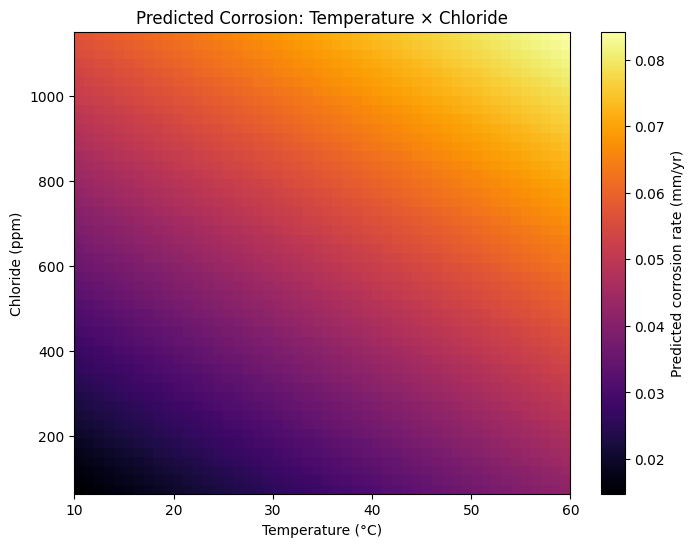

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(Z.T, origin="lower",
           extent=[temp_grid.min(), temp_grid.max(), cl_grid.min(), cl_grid.max()],
           aspect="auto", cmap="inferno")
plt.colorbar(label="Predicted corrosion rate (mm/yr)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Chloride (ppm)")
plt.title("Predicted Corrosion: Temperature × Chloride")
plt.show()

## Additional Model Performance Metrics

Additional regression metrics are computed to provide a more comprehensive assessment of model performance.  
These include absolute and squared error measures, adjusted R² to account for model complexity, and summary statistics of the target variable for contextual interpretation.


In [ ]:
# -------------------------------
# --- Additional Diagnostic Metrics ---
# -------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_y = np.std(y_test)
mean_y = np.mean(y_test)
range_y = np.max(y_test) - np.min(y_test)
n, p = X_test.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


## Relative Error Analysis

Relative error metrics are calculated by normalizing absolute error measures with respect to the target variable’s mean and range.  
These metrics provide practical context for interpreting model error magnitude relative to typical corrosion rates.


In [ ]:
# Relative errors
relative_mae_range = mae / range_y * 100
relative_mae_mean = mae / mean_y * 100
relative_rmse_mean = rmse / mean_y * 100


## Preserve Linear Regression Metrics

Key performance metrics from the linear regression model are stored separately to ensure they remain available for later comparison with more advanced models.


In [ ]:
# Save Linear Regression metrics (so XGBoost won't overwrite them)
lr_r2 = r2
lr_mae = mae
lr_rmse = rmse
lr_adj_r2 = adj_r2


## Model Performance Summary and Interpretation

Model performance metrics are summarized to evaluate predictive accuracy and goodness of fit.  
Both absolute error measures and relative error percentages are reported to contextualize model accuracy with respect to the variability of corrosion rates in the dataset.

A brief interpretation is included to explain how numerical error values and R² should be understood in the context of limited target variance.


In [ ]:
print("\n--- Model Performance Summary ---")
print(f"R²:                 {r2:.3f}")
print(f"Adjusted R²:        {adj_r2:.3f}")
print(f"MAE:                {mae:.5f}")
print(f"RMSE:               {rmse:.5f}")
print(f"Target std:         {std_y:.5f}")
print(f"Target range:       {range_y:.5f}")
print(f"Mean corrosion rate:{mean_y:.5f}")
print(f"Rel MAE (% of range): {relative_mae_range:.2f}%")
print(f"Rel MAE (% of mean):  {relative_mae_mean:.2f}%")
print(f"Rel RMSE (% of mean): {relative_rmse_mean:.2f}%")

print("\nInterpretation:")
print("- Small MAE/RMSE compared with the target’s mean or range means numerically accurate predictions.")
print("- Low R² may occur because corrosion rates vary only slightly (small variance).")
print("- Report both absolute and relative errors to show practical accuracy.")



--- Model Performance Summary ---
R²:                 0.382
Adjusted R²:        0.163
MAE:                0.00975
RMSE:               0.01448
Target std:         0.01841
Target range:       0.07220
Mean corrosion rate:0.04329
Rel MAE (% of range): 13.50%
Rel MAE (% of mean):  22.51%
Rel RMSE (% of mean): 33.44%

Interpretation:
- Small MAE/RMSE compared with the target’s mean or range means numerically accurate predictions.
- Low R² may occur because corrosion rates vary only slightly (small variance).
- Report both absolute and relative errors to show practical accuracy.


##  Dataset Augmentation for Visualization

The trained regression model is applied to the full dataset to generate predicted corrosion rates.  
These predictions are appended to the original dataset to support downstream visualization and exploratory analysis in external tools such as Tableau.


In [ ]:
# 8. Export dataset for Tableau
# -------------------------------

# Predict for all rows using the trained regression model
df["predicted_corrosion_mm_per_yr"] = model.predict(X)


##  Remaining Useful Life (RUL) Calculation

Remaining Useful Life (RUL) is estimated by converting predicted corrosion rates into time-to-failure using an assumed allowable material loss.  
This transformation translates model predictions into reliability-oriented metrics suitable for asset integrity assessment.


In [ ]:
#Compute Remaining Useful Life (RUL)
allowable_loss = 1.0  # mm
df["RUL_years"] = allowable_loss / df["predicted_corrosion_mm_per_yr"]


##  Export Enriched Dataset for Dashboarding

The enriched dataset, including predicted corrosion rates and Remaining Useful Life (RUL), is exported as a CSV file.  
This file serves as the input for external visualization and dashboarding tools, enabling interactive exploration of model outputs.


In [ ]:
# Save the enriched dataset (with predictions and RUL) for Tableau visualization
df.to_csv("corrosion_full_with_predictions.csv", index=False)

print("\n✅ Exported 'corrosion_full_with_predictions.csv' for Tableau dashboard.")
print(df.head())



✅ Exported 'corrosion_full_with_predictions.csv' for Tableau dashboard.
       timestamp    pH  temperature_C  chloride_ppm  dissolved_oxygen_mgL  \
0  7/1/2025 0:00  7.80      32.710718           216                  7.83   
1  7/1/2025 1:00  7.42      43.246618           189                  7.29   
2  7/1/2025 2:00  7.89      43.584807           241                  7.46   
3  7/1/2025 3:00  8.41      46.342352            89                  7.09   
4  7/1/2025 4:00  7.36      51.909469           212                  7.54   

   flow_velocity_mps  corrosion_rate_mm_per_yr  pH_squared  \
0              0.538                    0.0366     60.8400   
1              0.644                    0.0283     55.0564   
2              0.650                    0.0527     62.2521   
3              0.915                    0.0461     70.7281   
4              1.441                    0.0435     54.1696   

   predicted_corrosion_mm_per_yr  RUL_years  
0                       0.034364  29.100637  

## 33. XGBoost Regression Model Training and Evaluation

A gradient-boosted decision tree model (XGBoost) is trained to capture nonlinear relationships and feature interactions that may not be well represented by linear regression.  
Model performance is evaluated on the test dataset using MAE, RMSE, and R², and the results are compared against the linear regression baseline.


In [ ]:
from xgboost import XGBRegressor

# -------------------------------------------------------
# 4. Evaluate XGBoost Model
# -------------------------------------------------------


xgb = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))


print("\n=== XGBoost Regression Performance ===")
print(f"MAE:  {xgb_mae:.5f}")
print(f"RMSE: {xgb_rmse:.5f}")
print(f"R²:   {xgb_r2:.5f}")



=== XGBoost Regression Performance ===
MAE:  0.00881
RMSE: 0.01210
R²:   0.56813


##  Model Performance Comparison

Performance metrics from the linear regression and XGBoost models are consolidated into a comparison table.  
This side-by-side evaluation highlights differences in predictive accuracy and goodness of fit between linear and nonlinear modeling approaches.


In [ ]:


comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "XGBoost"],
    "MAE": [lr_mae, xgb_mae],
    "RMSE": [lr_rmse, xgb_rmse],
    "R²": [lr_r2, xgb_r2]
})

print("\n=== MODEL PERFORMANCE COMPARISON ===")
display(comparison_df.round(5))



=== MODEL PERFORMANCE COMPARISON ===


,Model,MAE,RMSE,R²
0,Linear Regression,0.00975,0.01448,0.38167
1,XGBoost,0.00842,0.01182,0.58798


In [ ]:
# !pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [ ]:
#import torch
#import torch.nn as nn
#from torch.utils.data import TensorDataset, DataLoader

Train/Val/Test split + Standardization

##  Data Preparation for Neural Network Modeling

The dataset is split into training, validation, and test subsets to support neural network training and unbiased performance evaluation.  
Input features are standardized to improve numerical stability and convergence, and the resulting datasets are converted into PyTorch tensors for model training.


In [ ]:

# X = df[features]
# y = df["corrosion_rate_mm_per_yr"]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Convert to torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


## DataLoader Construction for Mini-Batch Training

PyTorch DataLoader objects are created for the training and validation datasets.  
Mini-batch loading enables efficient gradient-based optimization and supports stable neural network training.


In [ ]:
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)


## Neural Network Architecture Definition (MLP)

A multi-layer perceptron (MLP) regression model is defined using fully connected layers with ReLU activation functions and dropout regularization.  
This architecture is designed to capture nonlinear relationships while mitigating overfitting through regularization.


In [ ]:
class MLPRegressor(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLPRegressor(n_features=X_train_t.shape[1])


## Neural Network Training with Early Stopping

The MLP model is trained using the Adam optimizer and mean squared error (MSE) loss.  
Training is performed using mini-batches, with validation loss monitored at each epoch.  
Early stopping is applied to prevent overfitting by retaining the model state that achieves the lowest validation error.


In [ ]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

max_epochs = 300
patience = 25  # early stopping patience
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

train_losses, val_losses = [], []

for epoch in range(max_epochs):
    # ---- train ----
    model.train()
    epoch_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * xb.size(0)
    epoch_train_loss /= len(train_loader.dataset)

    # ---- validate ----
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            epoch_val_loss += loss.item() * xb.size(0)
    epoch_val_loss /= len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # Early stopping check
    if epoch_val_loss < best_val_loss - 1e-6:
        best_val_loss = epoch_val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1:03d} | Train MSE: {epoch_train_loss:.6f} | Val MSE: {epoch_val_loss:.6f}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best Val MSE: {best_val_loss:.6f}")
        break

# Load best model
model.load_state_dict(best_state)


Epoch 025 | Train MSE: 0.000796 | Val MSE: 0.000365
Epoch 050 | Train MSE: 0.000507 | Val MSE: 0.000217
Epoch 075 | Train MSE: 0.000335 | Val MSE: 0.000170
Epoch 100 | Train MSE: 0.000204 | Val MSE: 0.000143
Early stopping at epoch 123. Best Val MSE: 0.000137


<All keys matched successfully>

## Training and Validation Loss Curves

Training and validation loss curves are plotted to assess convergence behavior and model generalization.  
Consistent reduction and stabilization of validation loss indicate effective learning, while divergence may suggest overfitting.


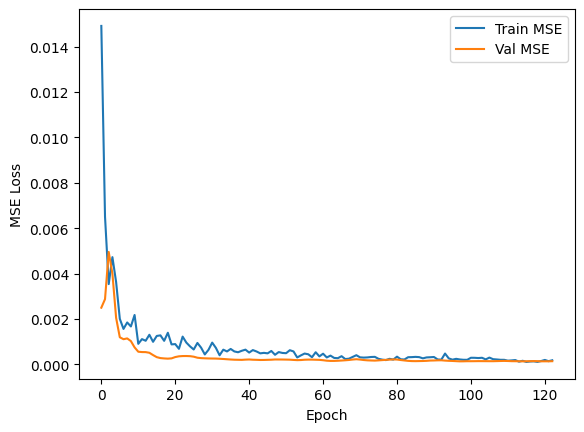

In [ ]:
#import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


##  Neural Network Test Set Evaluation

The trained MLP model is evaluated on the held-out test dataset to assess its generalization performance.  
Prediction accuracy is quantified using MAE, RMSE, and R², enabling direct comparison with regression and tree-based models.


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).numpy().reshape(-1)

y_true_test = y_test.values

nn_mae = mean_absolute_error(y_true_test, y_pred_test)
nn_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
nn_r2 = r2_score(y_true_test, y_pred_test)

print("=== Neural Network (MLP) Test Metrics ===")
print(f"MAE : {nn_mae:.6f}")
print(f"RMSE: {nn_rmse:.6f}")
print(f"R^2 : {nn_r2:.6f}")


=== Neural Network (MLP) Test Metrics ===
MAE : 0.011188
RMSE: 0.016261
R^2 : 0.219993


##  Final Model Comparison

Performance metrics from linear regression, XGBoost, and the neural network (MLP) are consolidated into a single comparison table.  
Sorting models by RMSE highlights relative predictive accuracy and supports objective comparison between linear, tree-based, and neural approaches.


In [ ]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "XGBoost", "Neural Net (MLP)"],
    "MAE":  [lr_mae, xgb_mae, nn_mae],
    "RMSE": [lr_rmse, xgb_rmse, nn_rmse],
    "R²":   [lr_r2,  xgb_r2,  nn_r2]
})

comparison_df.sort_values("RMSE")

,Model,MAE,RMSE,R²
1,XGBoost,0.008805,0.012100,0.568133
0,Linear Regression,0.009747,0.014478,0.381666
2,Neural Net (MLP),0.011188,0.016261,0.219993


Model Comparison and Interpretation
Tree-based ensemble models (XGBoost) achieved the best predictive performance on this tabular corrosion dataset, consistent with prior findings that gradient boosting performs strongly on structured data. Linear regression models retained competitive performance due to physics-aligned feature engineering. The neural network (MLP), while capable of learning nonlinear relationships, underperformed relative to XGBoost, likely due to dataset size and the limited benefit of representation learning in low-dimensional, structured data. These results highlight the trade-off between model complexity and inductive bias in applied ML systems.